## <u>*Classsification Modelling for Gender as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [2]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/new_cleaned_df.csv")

In [3]:
df.drop(["clm"],axis=1,inplace=True)

In [36]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport

---

*Date preprocessing*

In [6]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [7]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,severity,frequincy,pure_premium
14,1660.0,0.48,1,669.509999,9,3,1,1,6,670.0,2.06,1382.0
16,1510.0,0.99,1,806.609999,9,3,0,5,4,807.0,1.01,812.0
17,760.0,0.54,1,401.805451,3,3,1,2,4,402.0,1.85,745.0
40,1890.0,0.65,2,1811.709997,10,3,1,5,2,906.0,3.06,2769.0
64,4060.0,0.85,1,5434.439987,10,2,1,5,3,5434.0,1.17,6382.0


*Define x and y*

In [8]:
x=df.drop("gender",axis=1)
y=df["gender"]

*Splitting data into training and testing subsets*

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3699, 11) and Y = (3699,) : 
Test data shape of X = (925, 11) and Y = (925,) : 


*Data Scaling*

In [10]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [11]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "XGBRFClassifier": XGBRFClassifier(),
                "GradientBoostingClassifier":GradientBoostingClassifier(),
                "AdaBoostClassifier": AdaBoostClassifier()
                
            }

params={        
                "RandomForestClassifier":{
                    "n_estimators":[90,100,110], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.8,1],
                    "bootstrap":[True, False],                                                                                                    
                    "max_features":["sqrt","log2"],                                     
                    "max_depth":[2,3,4],
                    "criterion":['gini', 'entropy', 'log_loss']
                    },

                "DecisionTreeClassifier": {
                    'criterion':['gini', 'entropy', 'log_loss'],
                    'splitter': ['best', 'random'],
                    "max_depth":[2,3,4], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.5,0.8],
                    "max_features":['sqrt','log2'], 
                },
                "XGBRFClassifier":{
                    'learning_rate': [0.3,.5,1],    # 0.3 is the default
                    "max_depth":[5,6,7],
                    "subsample":[.8,1],
                    'n_estimators': [90, 100, 110], 
                    'colsample_bytree': [0.5,0.8], 
                    'colsample_bynode': [0.5,0.8],
                    "reg_lambda":[0,1,2],           #L2 regularization term on weights. Increasing this value will make model more conservative
                    "reg_alpha":[0,1,2]             #L1 regularization term on weights. Increasing this value will make model more conservative
                },

                
                "GradientBoostingClassifier":{
                    #'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate': [0.01,0.1,1],
                    'n_estimators': [90, 100, 110],
                    'subsample': [0.8,1],
                    #'criterion':['squared_error', 'friedman_mse'],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [0.8, 1],
                    'max_depth':[2,3,4],
                    'max_features': ['sqrt', 'log2']
                },
                "AdaBoostClassifier":{
                    'n_estimators': [45,50,55],
                    'learning_rate': [0.01,0.1,1]              
                }
                
            }

In [19]:
def evaluate_models(x_train,y_train,x_test,y_test,models,params):            
                report = {}
                #report2={}
                for i in tqdm(range(len(list(models)))):
                    model=list(models.values())[i]
                    para=params[list(models.keys())[i]]

                    RandomSearchCV=RandomizedSearchCV(model,param_distributions= para,cv=3)
                    RandomSearchCV.fit(x_train,y_train)

                    model.set_params(**RandomSearchCV.best_params_)
                    model.fit(x_train,y_train)

                    y_train_prediction=model.predict(x_train)
                    y_test_prediction=model.predict(x_test)

                    model_train_accuracy_score=accuracy_score(y_train,y_train_prediction)
                    model_test_accuracy_score=accuracy_score(y_test,y_test_prediction)

                    model_train_r2_score=r2_score(y_train,y_train_prediction)
                    model_test_r2_score=r2_score(y_test,y_test_prediction)

                    #report[list(models.keys())[i]] = model_train_mean_absolute_percentage_error
                    report[list(models.keys())[i]] = (model_train_accuracy_score,model_test_accuracy_score,
                                                      RandomSearchCV.best_params_)


                return report

In [20]:
model_report:dict=evaluate_models(x_train, y_train, x_test, y_test,models=models,params=params)

100%|██████████| 5/5 [00:30<00:00,  6.11s/it]


In [21]:
model_report

{'RandomForestClassifier': (0.6561232765612328,
  0.6205405405405405,
  {'n_estimators': 90,
   'min_samples_split': 6,
   'min_samples_leaf': 1,
   'max_features': 'log2',
   'max_depth': 4,
   'criterion': 'log_loss',
   'bootstrap': True}),
 'DecisionTreeClassifier': (0.5679913490132468,
  0.5913513513513513,
  {'splitter': 'random',
   'min_samples_split': 4,
   'min_samples_leaf': 0.8,
   'max_features': 'sqrt',
   'max_depth': 4,
   'criterion': 'gini'}),
 'XGBRFClassifier': (0.6669370100027034,
  0.625945945945946,
  {'subsample': 0.8,
   'reg_lambda': 0,
   'reg_alpha': 2,
   'n_estimators': 110,
   'max_depth': 5,
   'learning_rate': 1,
   'colsample_bytree': 0.8,
   'colsample_bynode': 0.5}),
 'GradientBoostingClassifier': (0.7483103541497702,
  0.6389189189189189,
  {'subsample': 0.8,
   'n_estimators': 110,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': 'log2',
   'max_depth': 4,
   'learning_rate': 0.1}),
 'AdaBoostClassifier': (0.6277372262773723,

In [22]:
model_report_df=pd.DataFrame(model_report).iloc[:-1] 

In [23]:
model_report_df

,RandomForestClassifier,DecisionTreeClassifier,XGBRFClassifier,GradientBoostingClassifier,AdaBoostClassifier
0,0.656123,0.567991,0.666937,0.74831,0.627737
1,0.620541,0.591351,0.625946,0.638919,0.619459


In [24]:
model_report_df["metrices"]=["model_train_accuracy_score","model_test_accuracy_score"]

In [25]:
model_report_df

,RandomForestClassifier,DecisionTreeClassifier,XGBRFClassifier,GradientBoostingClassifier,AdaBoostClassifier,metrices
0,0.656123,0.567991,0.666937,0.74831,0.627737,model_train_accuracy_score
1,0.620541,0.591351,0.625946,0.638919,0.619459,model_test_accuracy_score


In [27]:
GradientBoostingClassifier_best_paramerts=[k[2] for i,k in model_report.items() if i=="GradientBoostingClassifier"]
GradientBoostingClassifier_best_paramerts

[{'subsample': 0.8,
  'n_estimators': 110,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'log2',
  'max_depth': 4,
  'learning_rate': 0.1}]

In [28]:
model=GradientBoostingClassifier(
    subsample=0.8,
    n_estimators= 110,
    min_samples_split= 2,
    min_samples_leaf= 1,
    max_features="log2",
    max_depth= 4,
    learning_rate=0.1).fit(x_train,y_train)

In [29]:
predicted=model.predict(x_test)

In [32]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       547
           1       0.54      0.43      0.48       378

    accuracy                           0.62       925
   macro avg       0.60      0.59      0.59       925
weighted avg       0.61      0.62      0.61       925



In [37]:
unique_labels(y_test)
labels=unique_labels(y_test)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(y_test, predicted),columns=col_names,index=index_names)

,predicted0,predicted1
Actual0,408,139
Actual1,214,164


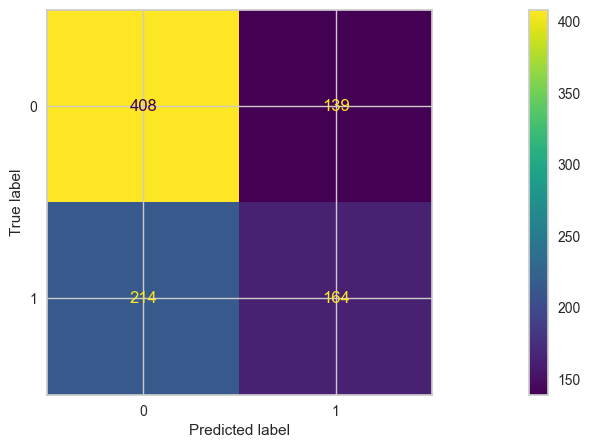

In [40]:
matplotlib.rcParams["figure.figsize"]=(25,5)
ConfusionMatrixDisplay(confusion_matrix(y_test,predicted)).plot()

In [41]:
from sklearn.multiclass import OneVsRestClassifier

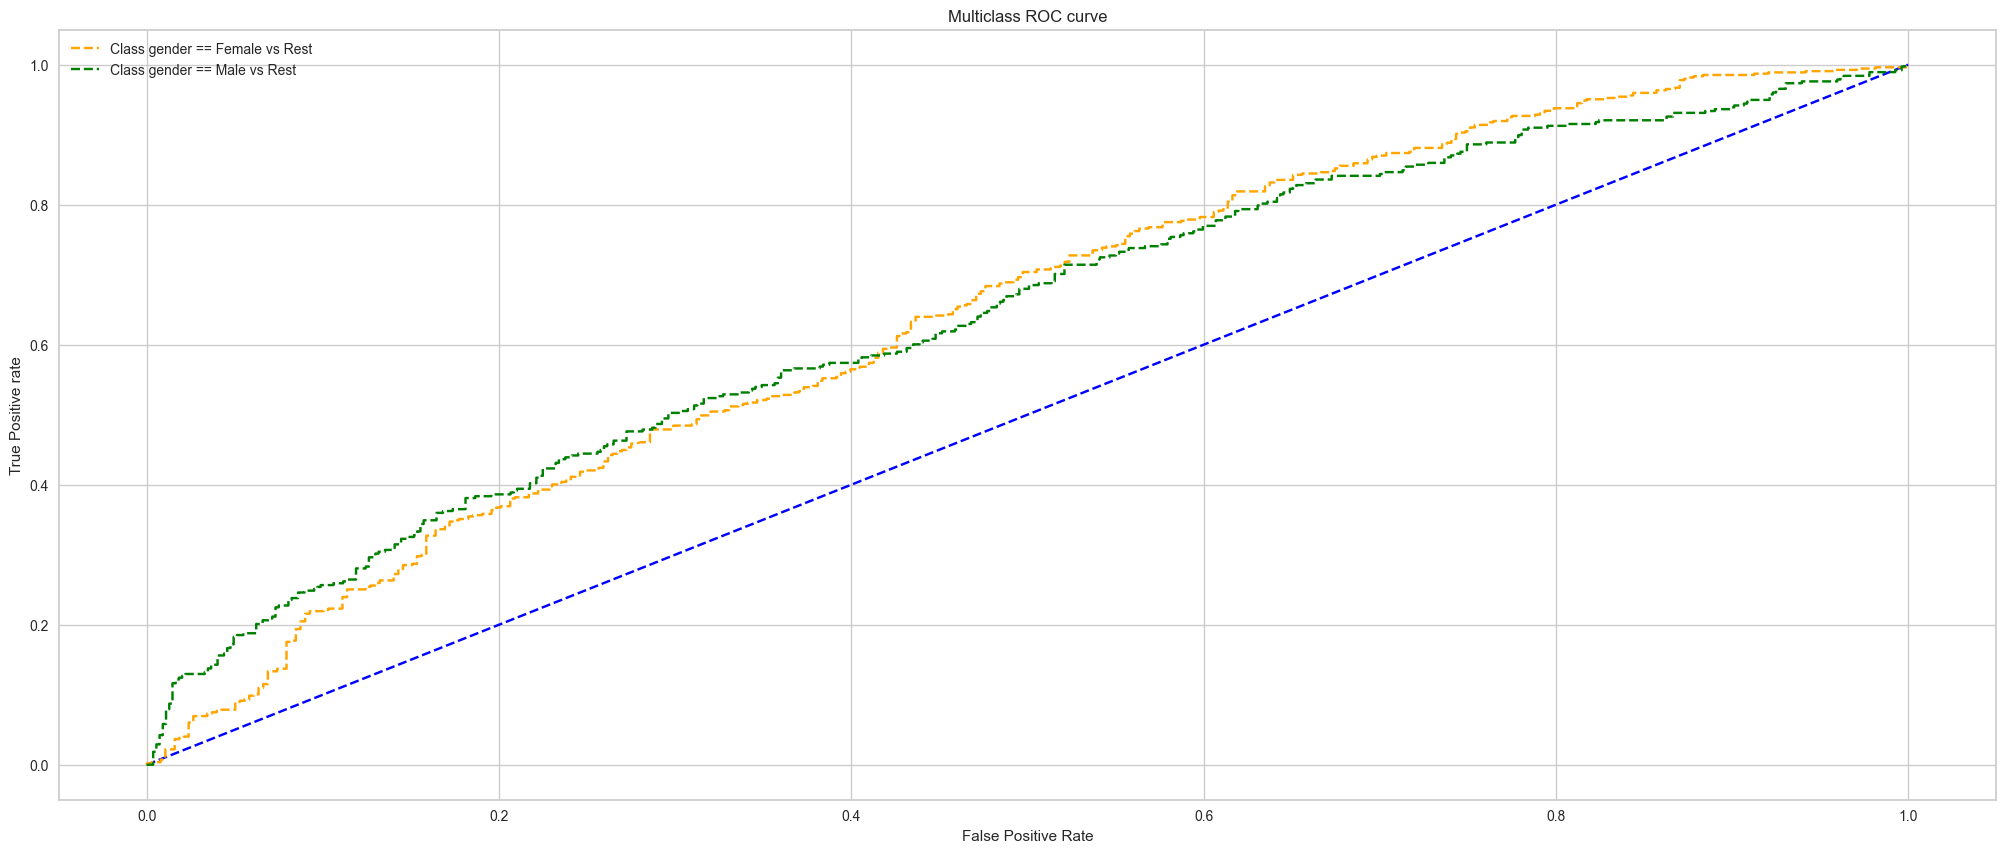

In [42]:
matplotlib.rcParams["figure.figsize"]=(25,10)
clf = OneVsRestClassifier(GradientBoostingClassifier(
                            subsample=0.8,
                            n_estimators= 110,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features="log2",
                            max_depth= 4,
                            learning_rate=0.1)).fit(x_train,y_train)


clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class gender == Female vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class gender == Male vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300);    


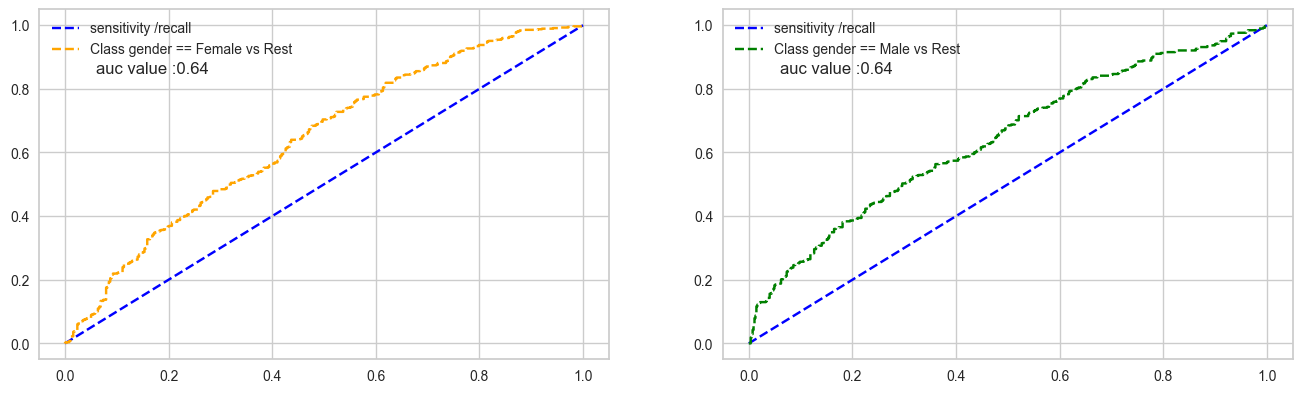

In [43]:
plt.subplot(231)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.06,0.85, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class gender == Female vs Rest'])

plt.subplot(232)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.06,0.85, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class gender == Male vs Rest'])

In [44]:
model.feature_names_in_=x.columns

In [45]:
importance=pd.concat([pd.DataFrame(model.feature_names_in_,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)

In [46]:
importance

,feature_names,feature_importances
0,veh_value,0.186541
1,exposure,0.061613
2,numclaims,0.006405
3,claimcst0,0.082158
4,veh_body,0.200169
5,veh_age,0.047813
6,area,0.040031
7,agecat,0.055013
8,severity,0.112699
9,frequincy,0.083581


In [52]:
PurePremiumImportanceTabel=importance.sort_values(by='feature_importances',ascending=False)
PurePremiumImportanceTabel.to_pickle("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Table/GenderImportanceTabel.pkl")

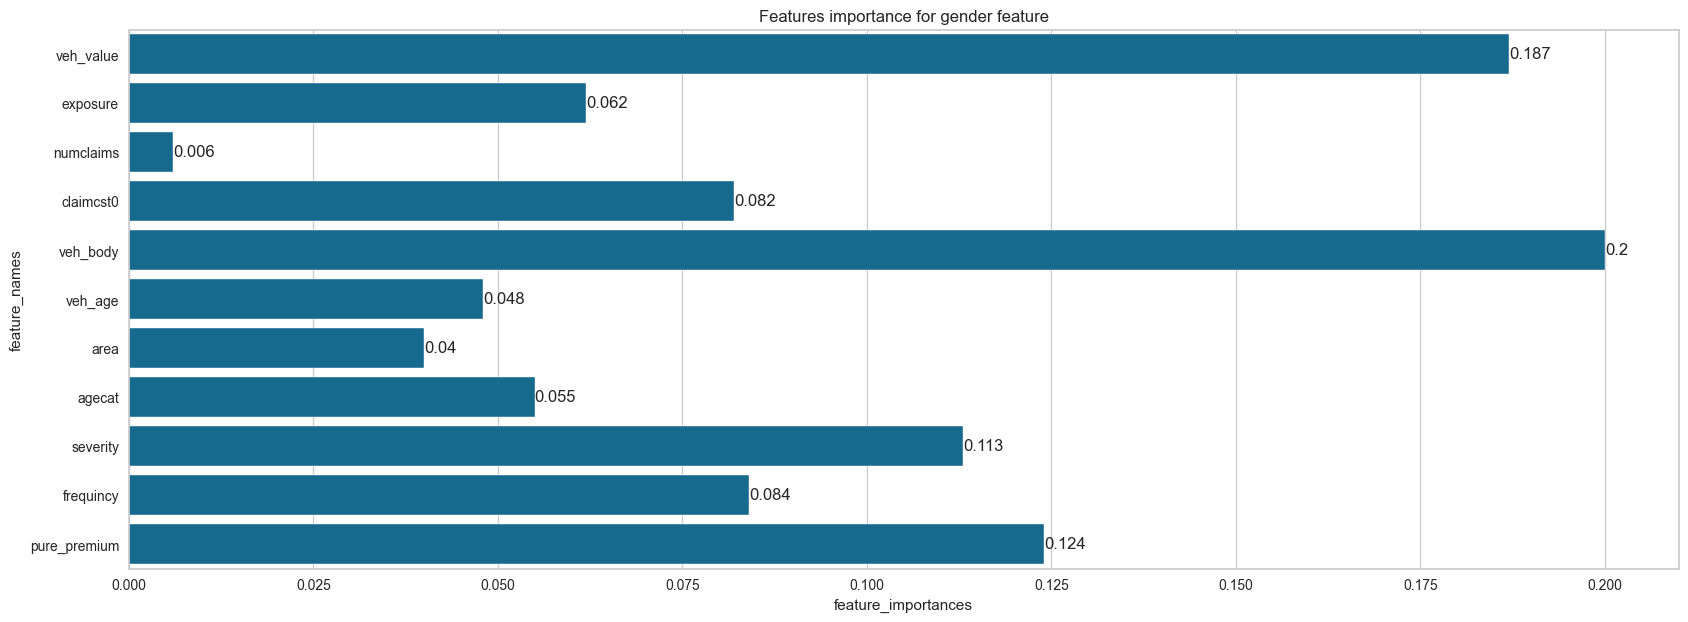

In [51]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for gender feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Graph/Gender_featureImportanc',dpi=500);

In [49]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/gender_prediction_model.pkl","wb") as f:
    pickle.dump(model,f)

---